<a href="https://colab.research.google.com/github/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import urllib.request
import zipfile

# Utilities

In [46]:
# Download data
def download_data(url, file_path):
  os.makedirs(file_path, exist_ok=True) # Create download file directory if it doesn't exist
  print('Successfully creating directory:', file_path)

  zip_path = os.path.join(file_path, 'AEP_hourly.csv.zip') # Define zip path for downloaded file

  urllib.request.urlretrieve(url, zip_path) # retreive file from url
  print('Downloaded file:', zip_path)

  # open and extract all files from zip
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)
    print('Extracted all files from:', zip_path)

  # remove zip file
  os.remove(zip_path)
  print('Removed zip file:', zip_path)

# Load data
def load_AEP_data(file_path):
  # csv file path
  csv_path = os.path.join(file_path, 'AEP_hourly.csv')

  # return pandas dataset format
  return pd.read_csv(csv_path, parse_dates=['Datetime']).sort_values('Datetime', ascending=True).reset_index()


# plot series
def plot_series(time, series,
                format='-', xlabel="Time", ylabel="Mv", title='Time Series Plot',
                start=0, end=None, label=None, color='skyblue', ax=None):

    if ax is None:
      fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(time[start:end], series[start:end], label=label, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label:
        ax.legend(fontsize=14)
    plt.grid(True)


# Download the data

In [47]:
# Dataset URL stored in github repository
DOWNLOAD_URL = 'https://github.com/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/raw/main/datasets/AEP_hourly.csv.zip'

# Directory where dataset will be stored
FILE_PATH = os.path.join(os.getcwd(), 'datasets')

# Download dataset
download_data(DOWNLOAD_URL, FILE_PATH)

Successfully creating directory: /content/datasets
Downloaded file: /content/datasets/AEP_hourly.csv.zip
Extracted all files from: /content/datasets/AEP_hourly.csv.zip
Removed zip file: /content/datasets/AEP_hourly.csv.zip


## Load Data

In [48]:
AEP_hourly = load_AEP_data(FILE_PATH)
AEP_hourly.head()

,index,Datetime,AEP_MW
0,2183,2004-10-01 01:00:00,12379.0
1,2184,2004-10-01 02:00:00,11935.0
2,2185,2004-10-01 03:00:00,11692.0
3,2186,2004-10-01 04:00:00,11597.0
4,2187,2004-10-01 05:00:00,11681.0


# Data Cleaning

When data is loaded, it sorted based on the `Datetime` column. It causes unsorted index value. So we have to reset the new index value and drop the unsorted index values.

In [49]:
# Drop index column
AEP_hourly.drop(columns=['index'], axis=1, inplace=True)
AEP_hourly.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [50]:
AEP_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [51]:
AEP_hourly.count()

,0
Datetime,121273
AEP_MW,121273


## Duplicate Value

In [14]:
AEP_hourly.duplicated().sum()
#No duplicate values

0

## Missing Value
Here we'll see the value that identified as `NULL` in the dataset. Then we sum it up

In [52]:
AEP_hourly.isnull().sum()
#No missing values=

,0
Datetime,0
AEP_MW,0


Good news, there no row that has a `NULL` value, is that means the dataset is free from missing value?. <br>

Let's go further analysis. We knew that the dataset formed as time series, so intuively we should check if the time is all recorded and there is no one left. Because in some case may happened when program is down and cannot record the data in certain time, so there is causes we lost some data in certain time.

In [53]:
# Ensure Datetime is in the correct format
AEP_hourly['Datetime'] = pd.to_datetime(AEP_hourly['Datetime'])

# Create a complete range of hours over the time period of your dataset
full_time_range = pd.date_range(start=AEP_hourly['Datetime'].min(),
                                end=AEP_hourly['Datetime'].max(),
                                freq='H')

# Find any missing hours
missing_hours = full_time_range.difference(AEP_hourly['Datetime'])

# Print missing hours
print("Missing hours:", missing_hours)

print("Total Number of actual time range:", len(full_time_range))
print("Total Number of currenct Dataset:", len(AEP_hourly))
print("Number of misisng hours:", len(missing_hours))

Missing hours: DatetimeIndex(['2004-10-31 02:00:00', '2005-04-03 03:00:00',
               '2005-10-30 02:00:00', '2006-04-02 03:00:00',
               '2006-10-29 02:00:00', '2007-03-11 03:00:00',
               '2007-11-04 02:00:00', '2008-03-09 03:00:00',
               '2008-11-02 02:00:00', '2009-03-08 03:00:00',
               '2009-11-01 02:00:00', '2010-03-14 03:00:00',
               '2010-11-07 02:00:00', '2010-12-10 00:00:00',
               '2011-03-13 03:00:00', '2011-11-06 02:00:00',
               '2012-03-11 03:00:00', '2012-11-04 02:00:00',
               '2012-12-06 04:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2014-03-11 14:00:00', '2015-03-08 03:00:00',
               '2016-03-13 03:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)
Total Number of actual time range: 121296
Total Number of currenct Dataset: 121273
Number of misisng hou

Exactly, we have an hours that missing. and it was `27` of the total missing values. So the thing we have to do is imputing the values to the missing hours using interpolation method

In [54]:
#  Step 1: Convert the Datetime column to datetime format
AEP_hourly['Datetime'] = pd.to_datetime(AEP_hourly['Datetime'])

# Step 2: Remove duplicates from the Datetime index if there are any
AEP_hourly = AEP_hourly.drop_duplicates(subset='Datetime')

# Step 3: Set the Datetime column as the index
AEP_hourly = AEP_hourly.set_index('Datetime')

# Step 5: Reindex to include all hours in the full time range
AEP_hourly = AEP_hourly.reindex(full_time_range)

# Step 6: Reset the index and rename the column to 'Datetime'
AEP_hourly.reset_index(inplace=True)
AEP_hourly.rename(columns={'index': 'Datetime'}, inplace=True)

# Step 7: Sort by Datetime (though this should be sorted already)
AEP_hourly = AEP_hourly.sort_values(by='Datetime', ascending=True)

# Display the first few rows
AEP_hourly.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


Now we check the total data after adding the missing hours. <br>
__The actual number of data should be `121286`__

In [55]:
print(f"Number of rows: ${AEP_hourly.shape[0]}")

Number of rows: $121296


Again, we identify missing value

In [56]:
AEP_hourly.isnull().sum()

,0
Datetime,0
AEP_MW,27


Yeay, we found out `27` missing values when the whole time range has been existed. Now we'll see the times that has missing value

In [57]:
missing_value_df = AEP_hourly[AEP_hourly['AEP_MW'].isnull()]
missing_value_df

,Datetime,AEP_MW
721,2004-10-31 02:00:00,NaN
4418,2005-04-03 03:00:00,NaN
9457,2005-10-30 02:00:00,NaN
13154,2006-04-02 03:00:00,NaN
18193,2006-10-29 02:00:00,NaN
21386,2007-03-11 03:00:00,NaN
27097,2007-11-04 02:00:00,NaN
30122,2008-03-09 03:00:00,NaN
35833,2008-11-02 02:00:00,NaN
38858,2009-03-08 03:00:00,NaN


As I promised, that we'll impute the value into misisng values using the interpolation method for handling this problem

When dealing with time series data of hourly energy usage, the best interpolation method depends on the **characteristics of the data** and the **behavior of the missing values**. Since energy usage typically follows some predictable daily and weekly patterns (often cyclical and somewhat smooth), here are the recommended interpolation methods and their applicability:

### 1. **Linear Interpolation** (Simple & Common)
   - **Method**: `'linear'`
   - **Description**: Fills missing values by drawing a straight line between the preceding and following data points.
   - **When to Use**:
     - If the data is relatively smooth and you expect the changes in energy usage to be gradual between hours.
     - Best for small gaps.
   - **Example**:
     ```python
     df['Value'] = df['Value'].interpolate(method='linear')
     ```

### 2. **Time-based Interpolation** (Handles Irregular Time Gaps)
   - **Method**: `'time'`
   - **Description**: Interpolates missing values according to the time differences between observations. This is especially useful when the time intervals are uneven.
   - **When to Use**:
     - If the time series data has unevenly spaced timestamps or irregular gaps between observations.
   - **Example**:
     ```python
     df['Value'] = df['Value'].interpolate(method='time')
     ```

### 3. **Polynomial Interpolation** (Curved Trends)
   - **Method**: `'polynomial'`
   - **Description**: Fits a polynomial function of a specified degree to interpolate missing values.
   - **When to Use**:
     - If you suspect the energy usage has some complex, nonlinear patterns (e.g., seasonal, daily cycles).
     - For small to moderate gaps. Be cautious about **overfitting** with high `order`.
   - **Example** (using 3rd-degree polynomial):
     ```python
     df['Value'] = df['Value'].interpolate(method='polynomial', order=3)
     ```

### 4. **Spline Interpolation** (Smooth Curves)
   - **Method**: `'spline'`
   - **Description**: Fits a spline (a smooth, flexible curve) of a specified degree to the data.
   - **When to Use**:
     - For smooth time series data where energy usage follows a continuous and cyclical pattern, like daily or weekly energy usage trends.
     - Best for medium-sized gaps.
   - **Example** (using cubic splines):
     ```python
     df['Value'] = df['Value'].interpolate(method='spline', order=3)
     ```

### 5. **Nearest Neighbor Interpolation** (Step-like Changes)
   - **Method**: `'nearest'`
   - **Description**: Fills missing values by copying the nearest available value.
   - **When to Use**:
     - If the energy usage fluctuates a lot and doesn't have smooth changes.
     - Works well if there are frequent sudden jumps or if precise trends are not important.
   - **Example**:
     ```python
     df['Value'] = df['Value'].interpolate(method='nearest')
     ```

### 6. **Backward/Forward Fill** (Constant Carryover)
   - **Method**: `'pad'` or `'ffill'` (Forward Fill), `'bfill'` (Backward Fill)
   - **Description**: Fills missing values by propagating the last known value forward or backward.
   - **When to Use**:
     - For constant or slowly changing patterns, where energy usage stays relatively stable between hours.
   - **Example** (forward fill):
     ```python
     df['Value'] = df['Value'].ffill()
     ```

### Recommended Method:
- **For Energy Usage Data**:
  - **Start with `linear` interpolation**. It's simple, effective for small gaps, and works well with smooth, gradual changes.
  - If the data has clear **cyclical patterns** (e.g., daily peaks and troughs), consider using **spline interpolation** or a **low-order polynomial (like `order=2 or 3`)** to better capture the trends.
  - If time gaps are uneven, use **`time` interpolation** to handle it correctly.

### Example Code:

```python
# Assume `df` is your DataFrame with missing hourly energy usage
df['Value'] = df['Value'].interpolate(method='linear')  # Start with linear interpolation
```

### Visualization:
It's always a good idea to **visualize** the data before and after interpolation to ensure that the chosen method fits the patterns in your energy usage data.

## Visualization

Look the big picture of the time series pattern from the whole datasets. We'll show it in the plot below

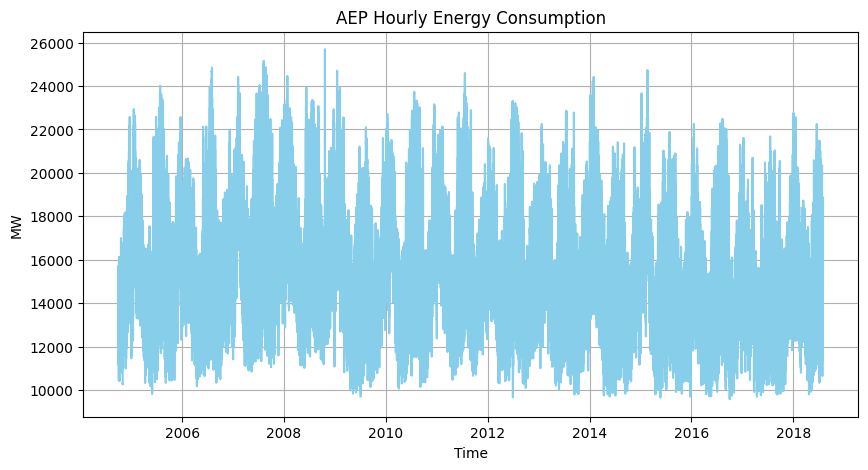

In [15]:

plot_series(AEP_hourly['Datetime'],
            AEP_hourly['AEP_MW'], xlabel='Time',
            ylabel='MW', title='AEP Hourly Energy Consumption')

The graph shows a clear trend where energy consumption from `2006-2010` was relatively higher, marked by frequent peaks reaching above `22,000 MW`. However, starting from 2010 onward, there is a noticeable decline in the consumption peaks, which stabilize and remain mostly below 20,000 MW in the later years.


Then, we'll try to take a look the seosonality more closely within a year. We've seen the data range is in hour steps. So to make the one year ranga of data we calculate `24 * 365`. Which `24` is hours a day, and `365` is days a year. <br>
<br>
For ease of organize the code, we declare variable for the ranges of datasets as below:<br>
```python
one_year = 24 * 365
one_month = 24 * 30
one_week = 24 * 7
one_day = 24
```

In [16]:
one_year = 24 * 365
one_month = 24 * 30
one_week = 24 * 7
one_day = 24

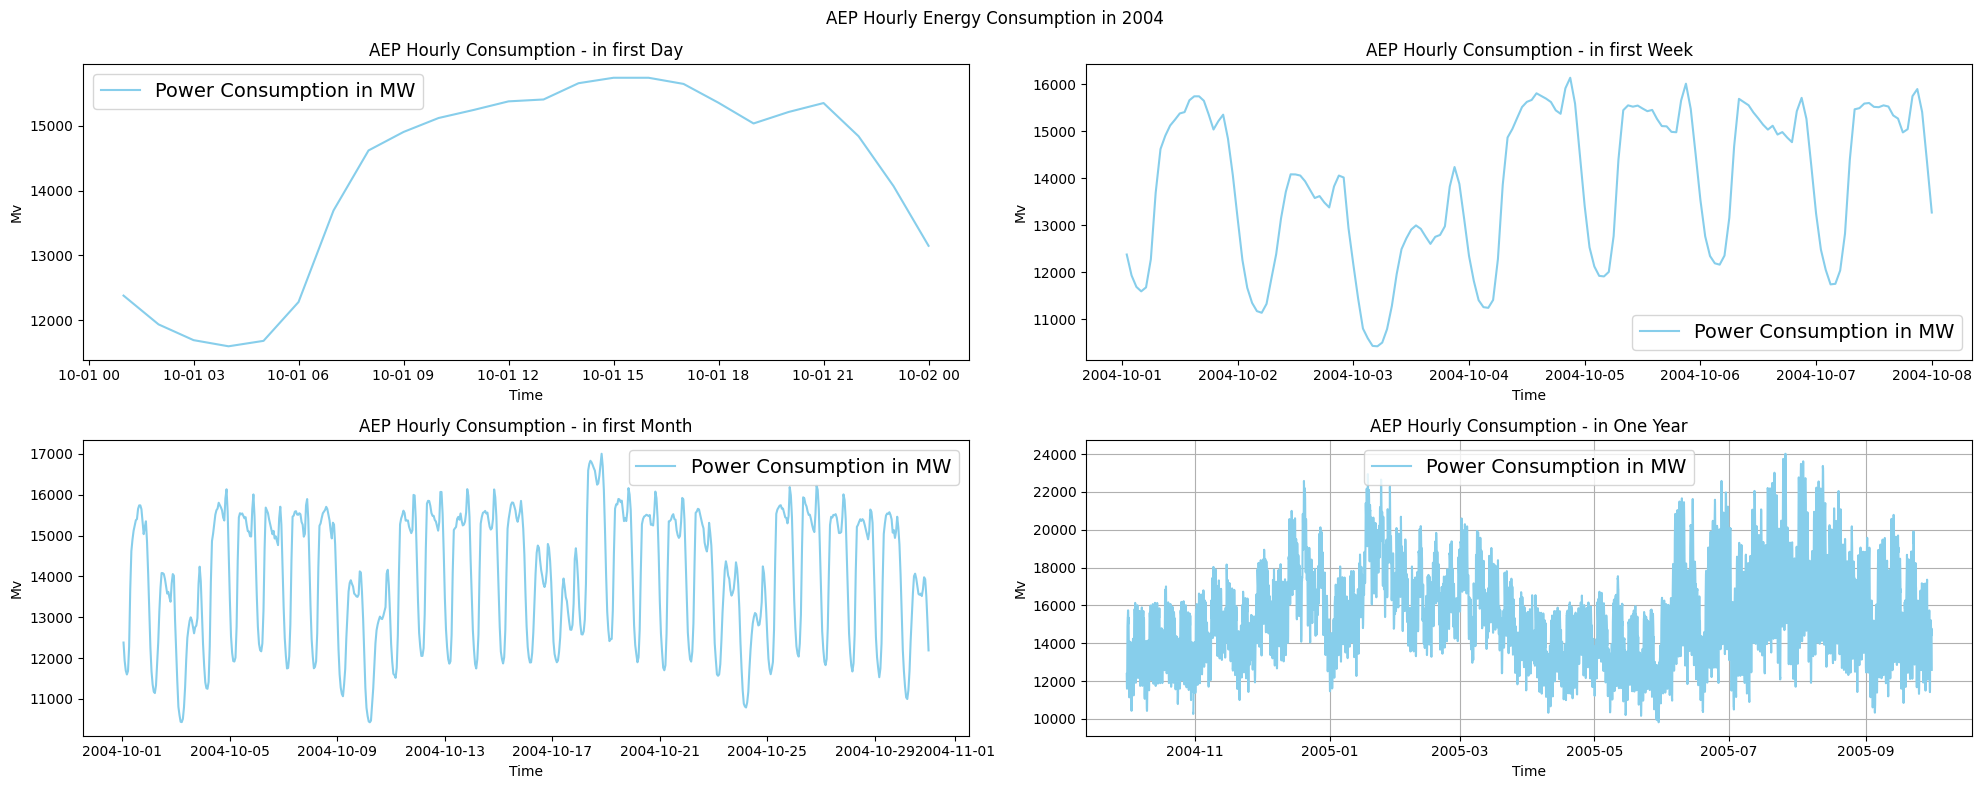

In [17]:
# Create subplots: 2 rows and 2 columns
fig, ax = plt.subplots(figsize=(20, 8), ncols=2, nrows=2)
fig.suptitle('AEP Hourly Energy Consumption in 2004')
# Plot for one day
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Day',
            start=0, end=one_day, label='Power Consumption in MW',
            ax=ax[0, 0])

# Plot for one week
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Week',
            start=0, end=one_week, label='Power Consumption in MW',
            ax=ax[0, 1])

# Plot for one month
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Month',
            start=0, end=one_month, label='Power Consumption in MW',
            ax=ax[1, 0])

# Plot for one year
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in One Year',
            start=0, end=one_year, label='Power Consumption in MW',
            ax=ax[1, 1])

# Adjust layout for better spacing
plt.tight_layout()


We're going to use the spline method with `order=3`

In [58]:
AEP_hourly['AEP_MW'] = AEP_hourly['AEP_MW'].interpolate(method='spline', order=3)

In [66]:
print(AEP_hourly.shape)
AEP_hourly.iloc[missing_value_df.index]

(121296, 2)


,Datetime,AEP_MW
721,2004-10-31 02:00:00,10743.750877
4418,2005-04-03 03:00:00,13362.475447
9457,2005-10-30 02:00:00,13147.458809
13154,2006-04-02 03:00:00,11258.025655
18193,2006-10-29 02:00:00,13134.499595
21386,2007-03-11 03:00:00,13004.567351
27097,2007-11-04 02:00:00,13343.704902
30122,2008-03-09 03:00:00,17169.374751
35833,2008-11-02 02:00:00,12285.017249
38858,2009-03-08 03:00:00,10998.648063


In [68]:
# download AEP_hourly data frame as csv file
from google.colab import files
AEP_hourly.to_csv('AEP_hourly_interpolated.csv', encoding = 'utf-8-sig')
files.download('AEP_hourly_interpolated.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Display the Distribution

In [18]:
def plot_dist(data, x, bins):
  fig, axs = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
  fig.suptitle('Distribution of AEP_MW')

  sns.histplot(data=data, x=x, bins=bins, color='skyblue', ax=axs[0], kde=True)
  sns.boxplot(data=data, x=x, color='skyblue', ax=axs[1])

  plt.tight_layout()

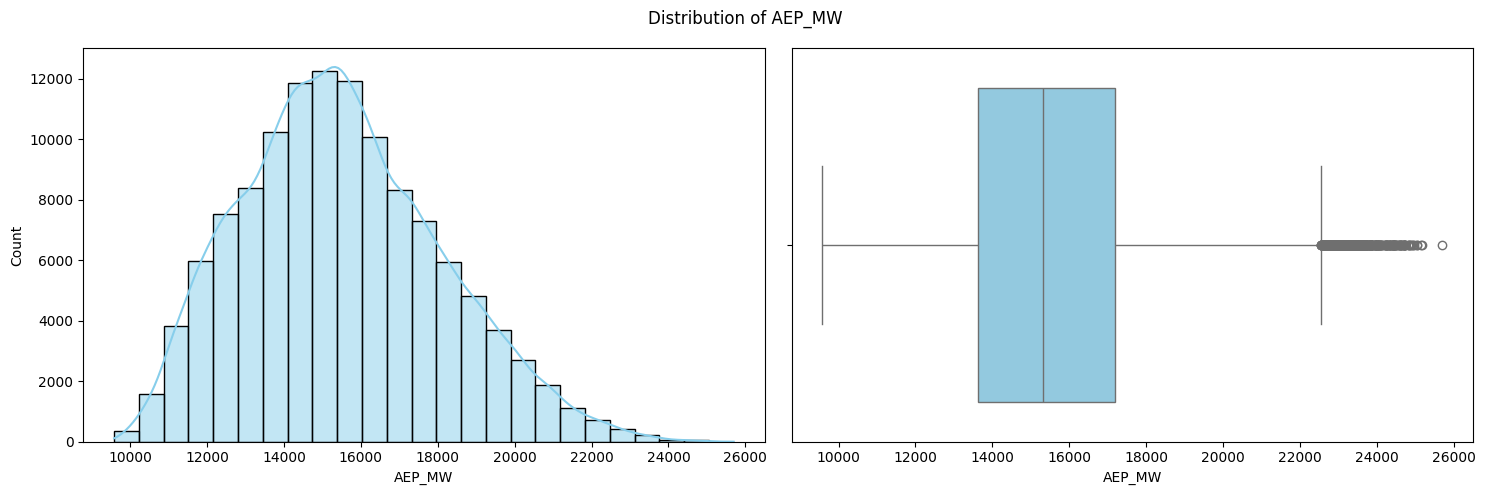

In [19]:
plot_dist(AEP_hourly, x='AEP_MW', bins=25)

The graph shows there is the outliers data. Which we'll handle it next.

## Check the outlier

Boxplot that displayed in the previous section tells that data has a outliers data point. Well, hecking for outliers in data can significantly improve the accuracy of calculating the mean and understanding the data's distribution, making it more normally distributed. On the other hand, outliers can distort the mean, leading to unreliable or skewed results.

In [20]:
def print_outliers(data, x):
  q1, q2, q3 = np.percentile(data[x], [25, 50, 75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  data = data[(data[x] < lower_bound) | (data[x] > upper_bound)]
  return data

In [21]:
outliers_data = print_outliers(AEP_hourly, 'AEP_MW')
outliers_data

,Datetime,AEP_MW


In [22]:
# Get the number of rows in the dataframe.
num_rows = outliers_data.shape[0]

# Print the number of rows.
print(f"Number of outliers data: {num_rows}")

# print the percentage of number of outliers
print(f"Percentage of outliers data: {round(num_rows / AEP_hourly.shape[0] * 100, 2)}%")

Number of outliers data: 0
Percentage of outliers data: 0.0%


The dataset contains 667 outliers, which represent approximately 0.55% of the total data. While this is a relatively small proportion, the presence of these outliers can still significantly distort the overall distribution and affect key statistics like the mean, potentially leading to misleading conclusions.
<br><br>
Therefore, the code below will drop that outliers data, then we'll see how it changes the distribution shape plot.

## Remove the outliers

 we'd like to remove the outliers data point for comaparation reason to show the diff statistial esetimate of data with and without outliers.

In [23]:
# Drop the outliers from the dataframe.
AEP_hourly_without_outliers = AEP_hourly.drop(outliers_data.index)

In [24]:
AEP_hourly_without_outliers.shape

(121296, 2)

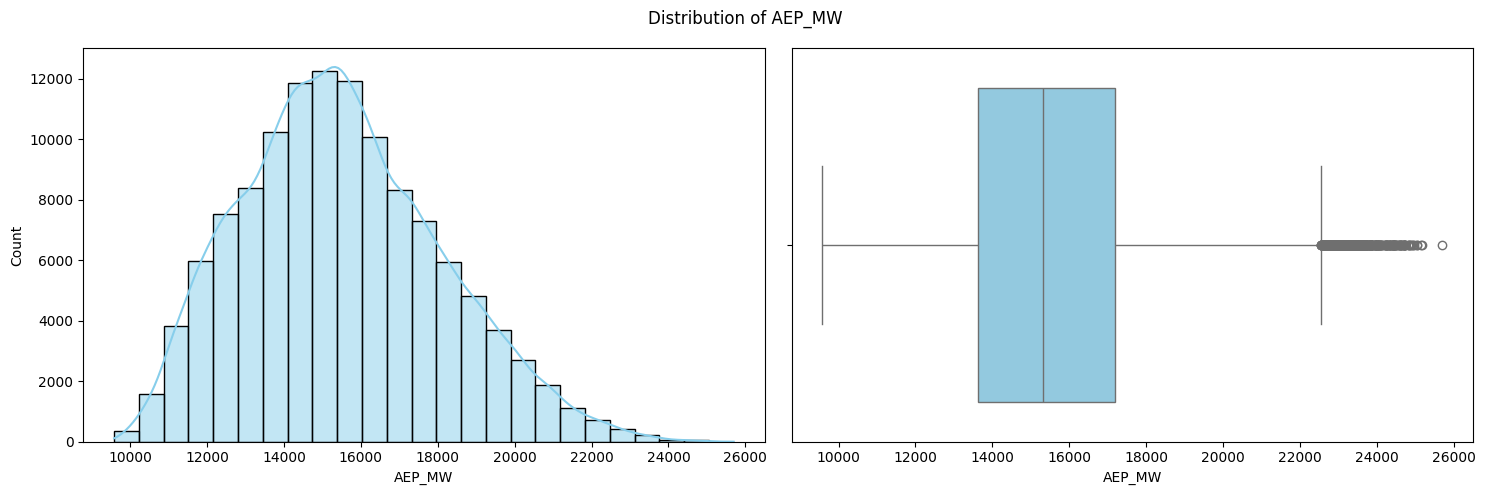

In [25]:
plot_dist(AEP_hourly_without_outliers, x='AEP_MW', bins=25)

The graph shows that the data distribution is closer to a normal (bell-shaped) distribution, indicating a more normal distribution overall. Althoug it isn't a perfect normal shape, it is much closer to normal compared to the distribution with outliers.

Now let's take a look for statistical analysis for both data

In [26]:
AEP_hourly.describe()

,Datetime,AEP_MW
count,121296,121269.000000
mean,2011-09-02 00:30:00,15499.652351
min,2004-10-01 01:00:00,9581.000000
25%,2008-03-17 12:45:00,13630.000000
50%,2011-09-02 00:30:00,15310.000000
75%,2015-02-16 12:15:00,17200.000000
max,2018-08-03 00:00:00,25695.000000
std,NaN,2591.321478


In [27]:
AEP_hourly_without_outliers.describe()

,Datetime,AEP_MW
count,121296,121269.000000
mean,2011-09-02 00:30:00,15499.652351
min,2004-10-01 01:00:00,9581.000000
25%,2008-03-17 12:45:00,13630.000000
50%,2011-09-02 00:30:00,15310.000000
75%,2015-02-16 12:15:00,17200.000000
max,2018-08-03 00:00:00,25695.000000
std,NaN,2591.321478


There is no significant diff of both data with or without outliers. But I rather to keep the outliers so that we're not missing the important event or value of time series data

# Exploratory Data Analysis

- AVG, mean, min, max consumption in whole data time
- AVG, mean, min, max consumption in each year, month, day, hour
- Which year has highest and lowest consumption
- Which month has highest consumption in every year
- Which day has highest consumption in every week
- Which hour has highest consumption in every day

In order to see the statistical estimeate in each year, month, day, and hour. We should create some additional correlated features. Below some categories that included.
- `Month name` = Jan - Dec
- `Quartiles` = Q1 - Q4 (The quartiles divide a set of observations into four sections, each representing 25% of the observations.)
- `Daytimes` = Late Night, Early Morning, Morning, Noon, Evening, Night

Here's how the day can be divided into your specified categories:

- **Late Night**: 12:00 AM – 3:00 AM
- **Early Morning**: 3:00 AM – 6:00 AM
- **Morning**: 6:00 AM – 12:00 PM
- **Noon**: 12:00 PM – 1:00 PM
- **Evening**: 5:00 PM – 8:00 PM
- **Night**: 8:00 PM – 12:00 AM

In [28]:
# column for year
AEP_hourly['year'] = pd.to_datetime(AEP_hourly['Datetime']).dt.year


# column for month
AEP_hourly['month_num'] = pd.to_datetime(AEP_hourly['Datetime']).dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
AEP_hourly['month_name'] = AEP_hourly['month_num'].apply(lambda x: month_names[x - 1])

# Added a label for the 4 quartiles in year
q1, q2, q3 = AEP_hourly['month_num'].quantile([0.25, 0.5, 0.75])
quartiles_in_years = ['Q1', 'Q2', 'Q3', 'Q4']
AEP_hourly['quartiles'] = pd.cut(AEP_hourly['month_num'], bins=[AEP_hourly['month_num'].min(), q1, q2, q3, AEP_hourly['year'].max()], labels=quartiles_in_years, include_lowest=True)

# column for day
AEP_hourly['day'] = pd.to_datetime(AEP_hourly['Datetime']).dt.day

# column for hour
# Create a new column for the hour
AEP_hourly['hour'] = pd.to_datetime(AEP_hourly['Datetime']).dt.hour
# Define the daytime categories and ensure they are evenly distributed over 24 hours
daytimes = ['Night', 'Morning', 'Noon', 'Evening']
# Use pd.cut to categorize the hours evenly (each category spans 6 hours)
AEP_hourly['daytime'] = pd.cut(AEP_hourly['hour'],
                               bins=[0, 6, 12, 18, 24],
                               labels=daytimes,
                               right=False,  # Exclude right edge of the interval
                               include_lowest=True)  # Include hour=0 in the first bin

In [29]:
AEP_hourly.head(10)

,Datetime,AEP_MW,year,month_num,month_name,quartiles,day,hour,daytime
0,2004-10-01 01:00:00,12379.0,2004,10,Oct,Q3,1,1,Night
1,2004-10-01 02:00:00,11935.0,2004,10,Oct,Q3,1,2,Night
2,2004-10-01 03:00:00,11692.0,2004,10,Oct,Q3,1,3,Night
3,2004-10-01 04:00:00,11597.0,2004,10,Oct,Q3,1,4,Night
4,2004-10-01 05:00:00,11681.0,2004,10,Oct,Q3,1,5,Night
5,2004-10-01 06:00:00,12280.0,2004,10,Oct,Q3,1,6,Morning
6,2004-10-01 07:00:00,13692.0,2004,10,Oct,Q3,1,7,Morning
7,2004-10-01 08:00:00,14618.0,2004,10,Oct,Q3,1,8,Morning
8,2004-10-01 09:00:00,14903.0,2004,10,Oct,Q3,1,9,Morning
9,2004-10-01 10:00:00,15118.0,2004,10,Oct,Q3,1,10,Morning


In [30]:
AEP_desc = AEP_hourly.describe()
AEP_desc

,Datetime,AEP_MW,year,month_num,day,hour
count,121296,121269.000000,121296.000000,121296.000000,121296.000000,121296.000000
mean,2011-09-02 00:30:00,15499.652351,2011.169684,6.500181,15.722415,11.500000
min,2004-10-01 01:00:00,9581.000000,2004.000000,1.000000,1.000000,0.000000
25%,2008-03-17 12:45:00,13630.000000,2008.000000,4.000000,8.000000,5.750000
50%,2011-09-02 00:30:00,15310.000000,2011.000000,6.000000,16.000000,11.500000
75%,2015-02-16 12:15:00,17200.000000,2015.000000,10.000000,23.000000,17.250000
max,2018-08-03 00:00:00,25695.000000,2018.000000,12.000000,31.000000,23.000000
std,NaN,2591.321478,4.011118,3.461518,8.802279,6.922215


In [31]:
print(f'timedelta: {AEP_desc.Datetime["max"].year - AEP_desc.Datetime["min"].year} years')

timedelta: 14 years


## Daily consumption
Now we'll see the time of highest consumption within the days

In [32]:
AEP_daily = AEP_hourly.groupby(['daytime']).agg({
  'AEP_MW': ['mean', 'sum', 'min', 'max','count', lambda x: x.max() - x.min()]
}).sort_values(by=('AEP_MW', 'max'), ascending=False)

AEP_daily.columns = ['_'.join(col).strip() for col in AEP_daily.columns.values]
AEP_daily.columns.values[-1] = 'AEP_minMax_range'
AEP_daily.reset_index(inplace=True)
AEP_daily

<ipython-input-32-121d2ba92637>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  AEP_daily = AEP_hourly.groupby(['daytime']).agg({


,daytime,AEP_MW_mean,AEP_MW_sum,AEP_MW_min,AEP_MW_max,AEP_MW_count,AEP_minMax_range
0,Noon,16481.662566,499773454.0,10511.0,25695.0,30323,15184.0
1,Evening,16553.061931,501955050.0,10904.0,24878.0,30324,13974.0
2,Morning,15379.358891,466363679.0,9604.0,24739.0,30324,15135.0
3,Night,13582.914978,411535158.0,9581.0,22693.0,30298,13112.0


## BUGS HERE!!!!
Shows that the highest consumption was in the noon time it's around `12pm-3pm` with `25695.0 MW` max consumption and `16475.857334 MV` in average, which is resonable where the citizen has a various activities. And the lowest is when the citizen or people don't do much activities which is in late night.
<br>

But if we looked at the mean and sum, it shows that higher consumption was in evening, means that generally or there is some bias in categorizing, we'll fix later>.>>


## Avg, min, max of usage consumption in each year

Now it's time to calculate avg, min, and max grouped by year

In [33]:
AEP_stat_in_years = AEP_hourly.groupby(['year']).agg({
      'AEP_MW': ['mean', 'min', 'max', lambda x: x.max() - x.min()]
  })

AEP_stat_in_years.columns = ['_'.join(col).strip() for col in AEP_stat_in_years.columns.values]
AEP_stat_in_years.columns.values[-1] = 'AEP_minMax_range'
AEP_stat_in_years.reset_index(inplace=True)
AEP_stat_in_years

,year,AEP_MW_mean,AEP_MW_min,AEP_MW_max,AEP_minMax_range
0,2004,15176.724388,10263.0,22577.0,12314.0
1,2005,15842.990865,9823.0,24015.0,14192.0
2,2006,15737.224252,10176.0,24842.0,14666.0
3,2007,16645.519297,10858.0,25164.0,14306.0
4,2008,16536.655659,11021.0,25695.0,14674.0
5,2009,15254.111669,9701.0,24703.0,15002.0
6,2010,16008.619504,10070.0,23736.0,13666.0
7,2011,15815.389472,10479.0,24597.0,14118.0
8,2012,15352.940667,9669.0,23320.0,13651.0
9,2013,15198.211578,9801.0,22858.0,13057.0


Table above shows the highest to the lowest average energy consumption in `14 years`. But we're wondering already which years that have highest and lowest consumption?. let's take look the next analysis

In [34]:
highest5_AEP_stat_in_years=AEP_stat_in_years.sort_values(by='AEP_MW_mean', ascending=False).head(5)
highest5_AEP_stat_in_years

,year,AEP_MW_mean,AEP_MW_min,AEP_MW_max,AEP_minMax_range
3,2007,16645.519297,10858.0,25164.0,14306.0
4,2008,16536.655659,11021.0,25695.0,14674.0
6,2010,16008.619504,10070.0,23736.0,13666.0
1,2005,15842.990865,9823.0,24015.0,14192.0
7,2011,15815.389472,10479.0,24597.0,14118.0


We've looked the table above shows the highest average energy consumption within 5 years. It turns out that year `2007` was the highest average energy consumption. And how about the lowest energy consumption. well, let's find out

In [35]:
lowest5_AEP_stat_in_years=AEP_stat_in_years.sort_values(by='AEP_MW_mean', ascending=True).head(5)
lowest5_AEP_stat_in_years

,year,AEP_MW_mean,AEP_MW_min,AEP_MW_max,AEP_minMax_range
13,2017,14484.199338,9698.0,21678.0,11980.0
12,2016,14784.655926,9581.0,22488.0,12907.0
11,2015,14869.416600,9662.0,24739.0,15077.0
10,2014,15169.304864,9707.0,24421.0,14714.0
0,2004,15176.724388,10263.0,22577.0,12314.0


In [36]:
diff = highest5_AEP_stat_in_years['AEP_MW_mean'].to_numpy() - lowest5_AEP_stat_in_years['AEP_MW_mean'].to_numpy()
diff

array([2161.31995882, 1751.99973308, 1139.20290433,  673.68600137,
        638.66508445])

Shows that the year 2017 has the lowest average consumption, which has average consumption around `14483 MW`. That difference of the highest consumption which is `16490 MW` is around `2006 MW`. Now we'll see the distribution of the average consumption in 14 years.

In [37]:
stat_in_year_outliers = print_outliers(AEP_stat_in_years, 'AEP_MW_mean').shape[0] # count the outliers
print(f'Number of outliers: {stat_in_year_outliers}')

Number of outliers: 0


Nice, there is no outliers in annual average consumption data. Next, we would like to see the average consumption in quartiles

In [38]:
AEP_stat_in_quartiles = AEP_hourly.groupby(['quartiles']).agg({
      'AEP_MW': ['mean', 'min', 'max', lambda x: x.max() - x.min()]
  }).sort_values(by=('AEP_MW', 'mean'), ascending=False)

AEP_stat_in_quartiles.columns = ['_'.join(col).strip() for col in AEP_stat_in_quartiles.columns.values]
AEP_stat_in_quartiles.columns.values[-1] = 'AEP_minMax_range'
AEP_stat_in_quartiles.reset_index(inplace=True)
AEP_stat_in_quartiles

<ipython-input-38-4f6132e922a0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  AEP_stat_in_quartiles = AEP_hourly.groupby(['quartiles']).agg({


,quartiles,AEP_MW_mean,AEP_MW_min,AEP_MW_max,AEP_minMax_range
0,Q1,15905.650321,9698.0,24739.0,15041.0
1,Q4,15701.326939,9708.0,23158.0,13450.0
2,Q3,15342.168308,9581.0,25695.0,16114.0
3,Q2,14804.899395,9662.0,23938.0,14276.0


Interesting shows that the highest average consumption is in the first quartile around `15906 MW` and the lowest happened in the second quartile around `14805 MW`.
Another interesting event that the higher and the lowesst consumption are happened in the third quartile which is `25695.0 MW` and `9581.0 MW` respectively

## Avg, min, max of usage consumption in each month

Now let's jump in to analize the statistical in each month

In [39]:
AEP_stat_in_months = AEP_hourly.groupby(['month_num', 'month_name']).agg({
      'AEP_MW': ['mean', 'min', 'max', lambda x: x.max() - x.min()]
  })

AEP_stat_in_months.columns = ['_'.join(col).strip() for col in AEP_stat_in_months.columns.values]
AEP_stat_in_months.columns.values[-1] = 'AEP_minMax_range'
AEP_stat_in_months.reset_index(inplace=True)
AEP_stat_in_months

,month_num,month_name,AEP_MW_mean,AEP_MW_min,AEP_MW_max,AEP_minMax_range
0,1,Jan,17431.269009,10840.0,24703.0,13863.0
1,2,Feb,17022.815084,10463.0,24739.0,14276.0
2,3,Mar,15376.835720,9917.0,22556.0,12639.0
3,4,Apr,13823.857511,9698.0,19390.0,9692.0
4,5,May,14006.393817,9662.0,22549.0,12887.0
5,6,Jun,15630.021825,9669.0,23938.0,14269.0
6,7,Jul,16349.853303,9701.0,24597.0,14896.0
7,8,Aug,16424.881699,10214.0,25164.0,14950.0
8,9,Sep,14657.280556,9801.0,23605.0,13804.0
9,10,Oct,13938.926431,9581.0,25695.0,16114.0
